In [1]:
library(patchwork)
library(tidymodels)

library(tidyverse)
library(repr)
library(infer)
library(lubridate)

options(repr.matrix.max.rows = 6)
library(dplyr)


── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──


## Merge dataframe

In [2]:
set.seed(1)
setwd("/home/jovyan/work/Minecraft-DSCI100-Project/R code")
players <- read_csv("data/players.csv")
unclean_sessions <- read_csv("data/sessions.csv")

merged_df <- left_join(unclean_sessions, players, by = "hashedEmail")
glimpse(merged_df)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 1,535
Columns: 11
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ experience          <chr> "Regular", "Amateur", "Amateur", "Regular", "Amate…
$ subscribe           <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…
$ played_hours        <dbl> 223.1, 53.9, 150.0, 223.1, 53.9, 223.1, 56.1, 178.…
$ name                <chr> "Hiroshi", "Alex", "Delara", "Hiroshi", "Alex", "H…
$ gender              <chr> "Male", "Male", "Female", "Male", "Male", "Male", …
$ Age                 <dbl> 17, 17, 16, 17, 17, 17, 23, 19, 27, 17, 23, 16, 10…


## What does the data look like?

In [3]:
set.seed(1)

# make an hours logged column for each observation, where an observation is a single player
# Predictors: Play experience, hours logged, gender, and age
# Response: Subscribed to news letter?

gender_play_time <- merged_df |> group_by(gender) |> summarize(avg_hours = mean(played_hours))

#Notice, male, female, and non-binary make up a large majority of the player base. 
# For that reason they will be the only predictors

final_df <- merged_df |>   filter(gender %in% c("Female", "Male", "Non-binary")) |> mutate(subscribe = as_factor(subscribe))
glimpse(final_df)

Rows: 1,501
Columns: 11
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ experience          <chr> "Regular", "Amateur", "Amateur", "Regular", "Amate…
$ subscribe           <fct> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TR…
$ played_hours        <dbl> 223.1, 53.9, 150.0, 223.1, 53.9, 223.1, 56.1, 178.…
$ name                <chr> "Hiroshi", "Alex", "Delara", "Hiroshi", "Alex", "H…
$ gender              <chr> "Male", "Male", "Female", "Male", "Male", "Male", …
$ Age                 <dbl> 17, 17, 16, 17, 17, 17, 23, 19, 17, 23, 16, 10, 20…


# Prep for K-NN Classification

subscribe,count,percentage
<fct>,<int>,<dbl>
FALSE,94,6.262492
TRUE,1407,93.737508


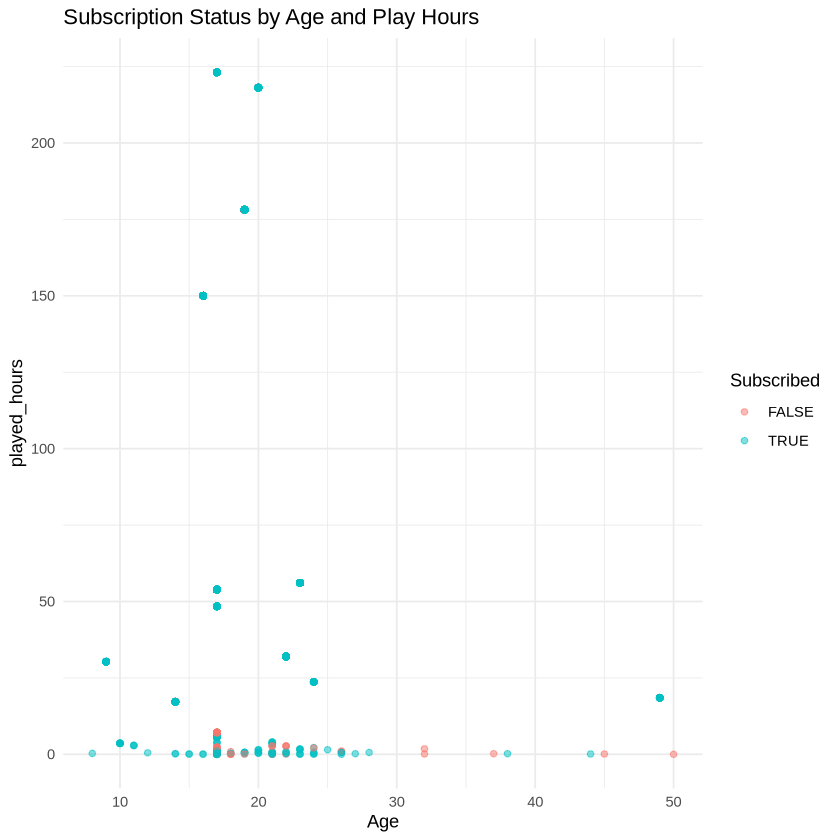

In [5]:
set.seed(1)

subscribed <- final_df |> 
  ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status by Age and Play Hours", color = "Subscribed") +
  theme_minimal()

num_obs <- nrow(final_df)
summary <- final_df |> 
            group_by(subscribe) |>
            summarize(count = n(), percentage = n() / num_obs *100)
summary
subscribed


In [9]:
set.seed(1)

sub_train <- final_df |> select(subscribe, Age, played_hours)

sub_split <- initial_split(sub_train, prop = 0.75, strata = subscribe)
sub_train <- training(sub_split)
sub_test <- testing(sub_split)


train_prop <- sub_train |>
            group_by(subscribe) |>
            summarize(n = n()) |>
            mutate(percent = 100* n/nrow(sub_train))
train_prop

sub_recipe <- recipe(subscribe ~., data = sub_train) |>
            step_scale(all_predictors())|>
            step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
            set_engine("kknn") |>
            set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(sub_recipe) |>
            add_model(knn_spec) |>
            fit(data = sub_train)
sub_test_predict <- predict(knn_fit, sub_test) |>
                    bind_cols(sub_test)  
metrics <- sub_test_predict |> 
            metrics(truth = subscribe, estimate = .pred_class) |>
                    filter(.metric == "accuracy")
metrics
confusion <- sub_test_predict |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

recall <- sub_test_predict |> recall(truth = subscribe, estimate = .pred_class, event_level = "first") |> pull()
precision <- sub_test_predict |> precision(truth = subscribe, estimate = .pred_class, event_level = "first") |> pull()

recall
precision
# at k = 3 we have very high recall and precision 
# This is a very good sign in that our model will be very accurate, now lets tune the model

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,72,6.4
TRUE,1053,93.6


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9734043


          Truth
Prediction FALSE TRUE
     FALSE    17    5
     TRUE      5  349

[1] 0.7727273

[1] 0.7727273

## Tune our model

In [10]:
set.seed(1)

# recreate the standardization recipe from before
# (since it must be based on the training data)
sub_fold <- vfold_cv(sub_train, v = 5, strata = subscribe)

knn_spec <- nearest_neighbor(
    weight_func = "rectangular",
    neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))  

# fit the knn model (we can reuse the old knn_spec model from before)
knn_results <- workflow() |>
  add_recipe(sub_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = sub_fold, grid = k_vals) |>
  collect_metrics()
accuracies <- knn_results |>
  filter(.metric == "accuracy")

k_plot <- accuracies |> ggplot(aes(x = neighbors, y = mean)) +
                        geom_point() +
                        geom_line() +
                        ggtitle("accuracy vs k")

# A tibble: 20 × 7
   neighbors .metric  .estimator  mean     n std_err .config              
       <dbl> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1         6 accuracy binary     0.974     5 0.00453 Preprocessor1_Model02
 2         1 accuracy binary     0.970     5 0.00495 Preprocessor1_Model01
 3        11 accuracy binary     0.968     5 0.00356 Preprocessor1_Model03
 4        16 accuracy binary     0.964     5 0.00569 Preprocessor1_Model04
 5        21 accuracy binary     0.961     5 0.00453 Preprocessor1_Model05
 6        26 accuracy binary     0.961     5 0.00453 Preprocessor1_Model06
 7        31 accuracy binary     0.96      5 0.00507 Preprocessor1_Model07
 8        36 accuracy binary     0.96      5 0.00507 Preprocessor1_Model08
 9        41 accuracy binary     0.96      5 0.00507 Preprocessor1_Model09
10        46 accuracy binary     0.96      5 0.00507 Preprocessor1_Model10
11        66 accuracy binary     0.951     5 0.00466 Preprocessor1_Model14
12    

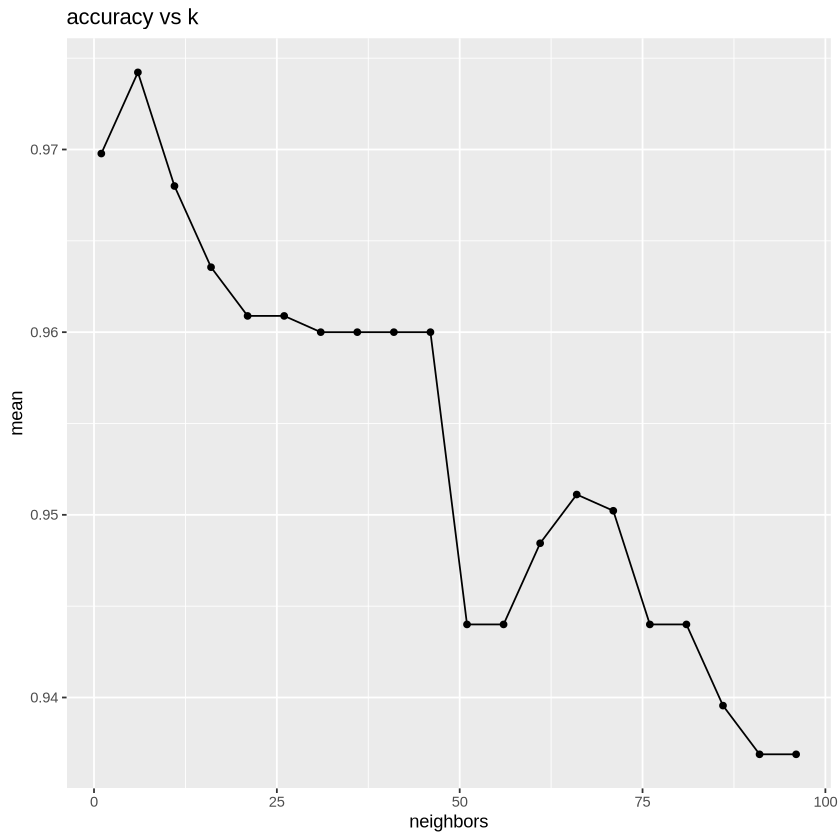

In [11]:
k_plot
best_k <- accuracies |> arrange(-mean) 
print(best_k)

## How does our model perform
- best k = 6
- recall = 0.773
- precision = 0.773


